<a href="https://colab.research.google.com/github/SergioMartinezCid/MUII-DSI-2022-23/blob/master/Clustering/DSI_Trabajo_Cl%C3%BAstering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de Datos

In [2]:
!wget -O CSVORIGINAL.csv https://raw.githubusercontent.com/SergioMartinezCid/MUII-DSI-2022-23/master/Clustering/CSVORIGINAL.csv

--2023-03-06 06:35:06--  https://raw.githubusercontent.com/SergioMartinezCid/MUII-DSI-2022-23/master/Clustering/CSVORIGINAL.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350830 (343K) [text/plain]
Saving to: ‘CSVORIGINAL.csv’

CSVORIGINAL.csv     100%[===================>] 342.61K  --.-KB/s    in 0.02s   

2023-03-06 06:35:06 (13.6 MB/s) - ‘CSVORIGINAL.csv’ saved [350830/350830]



In [3]:
# Imports
!pip install jackknife
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing 
min_max_scaler = preprocessing.MinMaxScaler()
from sklearn.decomposition import PCA
import sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
import plotly.express as px
from sklearn.cluster import DBSCAN
import jackknife as jk
from sklearn.mixture import GaussianMixture
from sklearn import metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 5.8 MB/s eta 0:00:00
  Created wheel for jackknife: filename=jackknife-0.1.0-py3-none-any.whl size=5291 sha256=0059b68e7bbe06224e022acda5f944ba5d1922f998848ab1f8eb4843cb4918a8
  Stored in directory: /root/.cache/pip/wheels/63/9b/9c/96153149e3993e66971eb32aca50bdb86780fbb0133dd76f50
Successfully built jackknife


In [4]:
original_df = pd.read_csv('CSVORIGINAL.csv', delimiter='\t', decimal=',')

In [5]:
# Se borra la última fila, que es nula
original_df = original_df.drop(3071, axis=0)
# Se elimina la columna prod100 por tener información agregada con scoring
original_df = original_df.drop(['prod100'], axis=1)
# Se eliminan las columnas de las tarjetas roja, amarilla y azul por no tener información relevante (hay muy pocas situaciones en las que se haya sacado tarjeta)
original_df = original_df.drop(['YC', 'RC', 'BC'], axis=1)
# Comprobamos si ha quedado algún valor nulo
print(original_df.isnull().values.any())
original_df.head()

False


,Phase,Match No.,Match,Team,No.,Name,7mGoals,7mMissed,6mGoals,6mMissed,...,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS,Time,scoring
0,Group Phase,1.0,EGY-CHI,EGY,5.0,OMAR Yahia,0.0,0.0,2.0,0.0,...,0.0,1.0,3.0,3.0,2.0,4.0,1.0,0.0,47.583333,1.75
1,Group Phase,1.0,EGY-CHI,EGY,11.0,MOAMEN Ahmed,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.033333,-0.40
2,Group Phase,1.0,EGY-CHI,EGY,15.0,HESHAM Ahmed,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,20.550000,-2.25
3,Group Phase,1.0,EGY-CHI,EGY,24.0,ELMASRY Ibrahim,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,29.800000,2.80
4,Group Phase,1.0,EGY-CHI,EGY,25.0,NAWAR Wisam,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.250000,0.00


-----
# Identificar los porteros

Vamos a eliminar los porteros y jugadores defensivos ya que como los datos son mayormente ofensivos, los va a agrupar todos en un solo cluster.

In [6]:
# Agrupamos por jugador
# Quitamos Phase, Match No., Match, No. y Team por ser columnas identificativas que no son relevantes para los jugadores (sólo se usará el nombre)
player_df = original_df.drop(['Phase', 'Match No.', 'Match', 'No.', 'Team'], axis=1)
# Establecer la columna Name como index porque es una columna identificativa
player_df = player_df.groupby(['Name'], as_index=False).sum()
#Seleccionamos los porteros que serán las filas que tienen tiempo pero 0 scoring
only_goalkeepers = player_df[(player_df.scoring==0)&(player_df.Time > 0)]
print(only_goalkeepers.shape)
only_goalkeepers.head()

(46, 22)


,Name,7mGoals,7mMissed,6mGoals,6mMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,...,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS,Time,scoring
7,ABIDI Mohamed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,146.783333,0.0
16,ALDERI Ali,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.866667,0.0
23,ALMEIDA Cesar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.533333,0.0
24,ALMEIDA Luis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.466667,0.0
28,ALSHUWAIKH Qasim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.733333,0.0


------
# Agregación de Datos

#### Por equipos (Incluyendo porteros)




In [7]:
# Quitamos Phase, Match No., Match, No. y Name por ser columnas identificativas que no son relevantes para los equipos
team_goalkeepers_df = original_df.drop(['Phase', 'Match No.', 'Match', 'No.', 'Name'], axis=1)

# Quitamos Time porque para los equipos no es relevante porque jugarán más los que lleguen a la final
team_goalkeepers_df = team_goalkeepers_df.drop('Time',axis=1)
# Quitamos Scoring porque es info agregada de los demás datos
team_goalkeepers_df = team_goalkeepers_df.drop('scoring',axis=1)
# Establecer la columna Team como index porque es una columna identificativa
team_goalkeepers_df = team_goalkeepers_df.groupby(['Team'], as_index=True).sum()

# Normalizamos los datos
team_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']] = min_max_scaler.fit_transform(team_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print (team_goalkeepers_df.shape)
team_goalkeepers_df.head()

(32, 19)


,7mGoals,7mMissed,6mGoals,6mMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,EGGoals,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS
Team,,,,,,,,,,,,,,,,,,,
ALG,0.464286,0.428571,0.305556,0.580645,0.265306,0.538462,0.600000,0.333333,0.062500,0.357143,0.454545,0.333333,0.508475,0.911765,0.546512,0.628571,0.259542,0.390244,0.100000
ANG,0.464286,1.000000,0.402778,0.354839,0.346939,0.269231,0.533333,0.066667,0.104167,0.357143,0.090909,0.166667,0.796610,0.882353,0.651163,0.600000,0.396947,0.195122,0.300000
ARG,0.250000,0.357143,0.347222,0.548387,0.244898,0.576923,0.333333,0.266667,0.333333,0.214286,0.545455,0.333333,0.203390,0.294118,0.546512,0.457143,0.244275,0.097561,0.100000
AUT,0.750000,0.428571,0.597222,0.387097,0.571429,0.461538,0.822222,0.200000,0.562500,0.642857,0.363636,0.500000,0.559322,0.661765,0.755814,0.828571,0.641221,0.707317,0.400000
BLR,0.214286,0.142857,0.500000,0.645161,0.612245,0.576923,0.400000,0.066667,0.229167,0.071429,0.272727,0.333333,0.677966,0.632353,0.488372,0.742857,0.374046,0.170732,0.433333


#### Por equipos (Excluyendo porteros)

In [8]:
# Eliminamos los porteros
team_no_goalkeepers_df = original_df.copy()
team_no_goalkeepers_df = team_no_goalkeepers_df[~team_no_goalkeepers_df['Name'].isin(only_goalkeepers['Name'])]
# Quitamos Phase, Match No., Match, No. y Name por ser columnas identificativas que no son relevantes para los equipos
team_no_goalkeepers_df = team_no_goalkeepers_df.drop(['Phase', 'Match No.', 'Match', 'No.', 'Name'], axis=1)
# Quitamos Time porque para los equipos no es relevante porque jugarán más los que lleguen a la final
team_no_goalkeepers_df = team_no_goalkeepers_df.drop('Time',axis=1)
# Quitamos Scoring porque es info agregada de los demás datos
team_no_goalkeepers_df = team_no_goalkeepers_df.drop('scoring',axis=1)
# Establecer la columna Team como index porque es una columna identificativa
team_no_goalkeepers_df = team_no_goalkeepers_df.groupby(['Team'], as_index=True).sum()
# Normalizamos los datos
team_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']] = min_max_scaler.fit_transform(team_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])

team_no_goalkeepers_df.head()

,7mGoals,7mMissed,6mGoals,6mMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,EGGoals,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS
Team,,,,,,,,,,,,,,,,,,,
ALG,0.464286,0.428571,0.305556,0.580645,0.265306,0.538462,0.600000,0.333333,0.062500,0.357143,0.454545,0.333333,0.508475,0.911765,0.546512,0.628571,0.259542,0.390244,0.100000
ANG,0.464286,1.000000,0.402778,0.354839,0.346939,0.269231,0.533333,0.066667,0.104167,0.357143,0.090909,0.166667,0.796610,0.882353,0.651163,0.600000,0.396947,0.195122,0.300000
ARG,0.250000,0.357143,0.347222,0.548387,0.244898,0.576923,0.333333,0.266667,0.333333,0.214286,0.545455,0.333333,0.203390,0.294118,0.546512,0.457143,0.244275,0.097561,0.100000
AUT,0.750000,0.428571,0.597222,0.387097,0.571429,0.461538,0.822222,0.200000,0.562500,0.642857,0.363636,0.500000,0.559322,0.661765,0.755814,0.828571,0.641221,0.707317,0.400000
BLR,0.214286,0.142857,0.500000,0.645161,0.612245,0.576923,0.400000,0.066667,0.229167,0.071429,0.272727,0.333333,0.677966,0.632353,0.488372,0.742857,0.374046,0.170732,0.433333


#### Por equipos (Excluyendo porteros y quitando los partidos de la president cup)

Ya que los partidos de la Presidents Cup son entre los equipos que quedaron de 25 a 32 de la clasificación, mete mucho ruido a los datos porque son partidos contra equipos muy malos. Por lo tanto, vamos a probar que pasa si eliminamos dichos partidos.

In [9]:
# Eliminamos los porteros
team_no_presidentscup_df = original_df.copy()
team_no_presidentscup_df = team_no_presidentscup_df[~team_no_presidentscup_df['Name'].isin(only_goalkeepers['Name'])]

#Quitamos los partidos que sean Presidents Cup
team_no_presidentscup_df = team_no_presidentscup_df[team_no_presidentscup_df['Phase'] != "President Cup"]
print (team_no_presidentscup_df.shape)
# Quitamos Phase, Match No., Match, No. y Name por ser columnas identificativas que no son relevantes para los equipos
team_no_presidentscup_df = team_no_presidentscup_df.drop(['Phase', 'Match No.', 'Match', 'No.', 'Name'], axis=1)
# Quitamos Time porque para los equipos no es relevante porque jugarán más los que lleguen a la final
team_no_presidentscup_df = team_no_presidentscup_df.drop('Time',axis=1)
# Quitamos Scoring porque es info agregada de los demás datos
team_no_presidentscup_df = team_no_presidentscup_df.drop('scoring',axis=1)
# Establecer la columna Team como index porque es una columna identificativa
team_no_presidentscup_df = team_no_presidentscup_df.groupby(['Team'], as_index=True).sum()
# Normalizamos los datos
team_no_presidentscup_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']] = min_max_scaler.fit_transform(team_no_presidentscup_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print (team_no_presidentscup_df.shape)
team_no_presidentscup_df.head()

(2536, 27)
(32, 19)


,7mGoals,7mMissed,6mGoals,6mMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,EGGoals,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS
Team,,,,,,,,,,,,,,,,,,,
ALG,0.464286,0.6,0.305556,0.580645,0.265306,0.666667,0.600000,0.3750,0.134615,0.357143,0.500000,0.4,0.508475,0.911765,0.671429,0.68750,0.259542,0.418605,0.100000
ANG,0.035714,0.6,0.138889,0.193548,0.224490,0.047619,0.155556,0.0625,0.000000,0.000000,0.083333,0.2,0.372881,0.397059,0.342857,0.34375,0.114504,0.000000,0.233333
ARG,0.250000,0.5,0.347222,0.548387,0.244898,0.714286,0.333333,0.3125,0.384615,0.214286,0.583333,0.4,0.203390,0.294118,0.671429,0.50000,0.244275,0.139535,0.100000
AUT,0.285714,0.3,0.152778,0.193548,0.142857,0.095238,0.244444,0.0000,0.076923,0.142857,0.000000,0.4,0.322034,0.279412,0.300000,0.31250,0.229008,0.139535,0.066667
BLR,0.214286,0.2,0.500000,0.645161,0.612245,0.714286,0.400000,0.1250,0.288462,0.071429,0.333333,0.4,0.677966,0.632353,0.600000,0.81250,0.374046,0.209302,0.433333


In [10]:
# Quitamos Phase, Match No., Match, No. y Team por ser columnas identificativas que no son relevantes para los jugadores
player_df = original_df.drop(['Phase', 'Match No.', 'Match', 'No.', 'Team'], axis=1)
# Quitamos Scoring porque es info agregada de los demás datos
player_df = player_df.drop('scoring',axis=1)

#### Por jugador (Incluyendo porteros)

In [11]:
# Establecer la columna Name como index porque es una columna identificativa
player_goalkeepers_df = player_df.groupby(['Name'], as_index=True).sum()
# Normalizamos los datos
player_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS', 'Time']] = min_max_scaler.fit_transform(player_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS', 'Time']])

player_goalkeepers_df.shape

(607, 20)

#### Por jugador (Excluyendo porteros)

In [12]:
player_no_goalkeepers_df = player_df.copy()
player_no_goalkeepers_df = player_no_goalkeepers_df[~player_no_goalkeepers_df['Name'].isin(only_goalkeepers['Name'])]
# Establecer la columna Name como index porque es una columna identificativa
player_no_goalkeepers_df = player_no_goalkeepers_df.groupby(['Name'], as_index=True).sum()
# Normalizamos los datos
player_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS', 'Time']] = min_max_scaler.fit_transform(player_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS', 'Time']])

player_no_goalkeepers_df.shape

(561, 20)

-----
# Aplicar PCA

Vamos a aplicar PCA para tener solo 5 atributos.
Para poder visualizar los componentes y detectar outliers visualmente se hará uso de los 2 atributos que conserven mayor varianza.

La varianza mantenida es baja, especialmente por jugadores. Probamos a cambiar el tipo de escalado de Minmax a Standard e incluso a dejarlo sin escalar, pero lo que da mejor resultado es Minmax.

In [13]:
estimator = PCA (n_components = 5)

#### Por equipos (Con porteros)

[0.44153827 0.13581882 0.07407444 0.0591404  0.04569744]


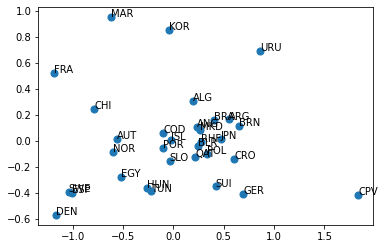

In [14]:

team_goalkeepers_df_pca = estimator.fit_transform(team_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print(estimator.explained_variance_ratio_) 

fig, ax = plt.subplots()
ax.scatter(team_goalkeepers_df_pca[:,0], team_goalkeepers_df_pca[:,1] ,s=50)

for i in range(0,len(team_goalkeepers_df_pca)):
    ax.annotate(team_goalkeepers_df.index[i], (team_goalkeepers_df_pca[i,0], team_goalkeepers_df_pca[i,1]))

Varianza mantenida: 0.75626937

Como los resultados no parecen variar demasiado entre equipos sin porteros y con porteros, solo usaremos a partir de ahora los datos de equipos sin porteros.

#### Por equipos (Sin porteros)

[0.4441231  0.13507756 0.0742958  0.05887682 0.04610971]


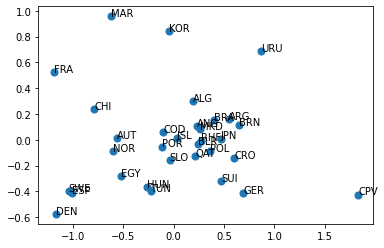

In [15]:
team_no_goalkeepers_df_pca = estimator.fit_transform(team_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print(estimator.explained_variance_ratio_) 


fig, ax = plt.subplots()
ax.scatter(team_no_goalkeepers_df_pca[:,0], team_no_goalkeepers_df_pca[:,1] ,s=50)

for i in range(0,len(team_no_goalkeepers_df_pca)):
    ax.annotate(team_no_goalkeepers_df.index[i], (team_no_goalkeepers_df_pca[i,0], team_no_goalkeepers_df_pca[i,1]))

Varianza mantenida: 0.75848299

Como los resultados no parecen variar demasiado entre equipos sin porteros y con porteros, solo usaremos a partir de ahora los datos de equipos sin porteros.

In [17]:
# Influencia de cada uno de las columnas en las componentes de PCA
pd.DataFrame(np.matrix.transpose(estimator.components_), columns=['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5'], index=team_no_goalkeepers_df.columns)

,PC-1,PC-2,PC-3,PC-4,PC-5
7mGoals,-0.260288,0.018918,-0.014998,0.481853,0.163036
7mMissed,-0.111384,0.261992,0.114526,-0.022518,-0.489723
6mGoals,-0.273953,-0.068783,0.089656,-0.059021,-0.062555
6mMissed,-0.191955,0.183164,0.227846,-0.015297,0.128295
WingGoals,-0.254052,-0.091871,-0.019105,0.365116,-0.141011
WingMissed,-0.149905,0.339507,-0.188706,0.016953,-0.287842
BTGoals,-0.233840,-0.065206,-0.047527,-0.031741,-0.222262
BTMissed,-0.189016,0.323256,-0.455778,-0.019472,0.075254
FBGoals,-0.313345,-0.188413,-0.285785,-0.090208,-0.006715
FBMissed,-0.274736,-0.046403,0.025692,0.029902,0.376566


#### Por equipos (sin presidents cup)

[0.56463144 0.09556199 0.06178521 0.04915448 0.04590264]


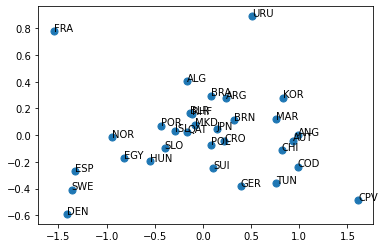

In [18]:
team_no_presidentscup_df_pca = estimator.fit_transform(team_no_presidentscup_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print(estimator.explained_variance_ratio_) 

fig, ax = plt.subplots()
ax.scatter(team_no_presidentscup_df_pca[:,0], team_no_presidentscup_df_pca[:,1] ,s=50)

for i in range(0,len(team_no_presidentscup_df_pca)):
    ax.annotate(team_no_presidentscup_df.index[i], (team_no_presidentscup_df_pca[i,0], team_no_presidentscup_df_pca[i,1]))


Varianza mantenida: 0.81703576

In [19]:
# Influencia de cada uno de las columnas en las componentes de PCA
pd.DataFrame(np.matrix.transpose(estimator.components_), columns=['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5'], index=team_no_presidentscup_df.columns)

,PC-1,PC-2,PC-3,PC-4,PC-5
7mGoals,-0.261770,-0.124299,-0.086968,-0.143550,-0.470663
7mMissed,-0.137109,0.308452,-0.415422,0.081956,0.444597
6mGoals,-0.265137,-0.049165,0.061442,0.040681,0.088961
6mMissed,-0.221925,0.215291,0.305074,-0.078800,0.102930
WingGoals,-0.279878,-0.025220,-0.095997,-0.250296,-0.121260
WingMissed,-0.188862,0.289027,-0.266522,-0.444236,0.048470
BTGoals,-0.238050,-0.056006,-0.173850,-0.034666,0.048164
BTMissed,-0.158903,0.184556,-0.384891,0.260845,-0.166239
FBGoals,-0.267583,-0.169417,-0.186487,0.075867,-0.055417
FBMissed,-0.253753,-0.168844,0.131627,0.195085,-0.355994


#### Por jugador (Con porteros)

[0.24948252 0.1988552  0.1051322  0.07097456 0.05542715]


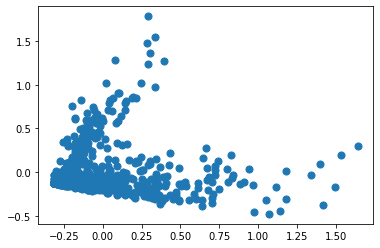

In [31]:
player_columns = ['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']
player_goalkeepers_df_pca = estimator.fit_transform(player_goalkeepers_df[player_columns])
print(estimator.explained_variance_ratio_)

fig, ax = plt.subplots()
ax.scatter(player_goalkeepers_df_pca[:,0], player_goalkeepers_df_pca[:,1] ,s=50)

for i in range(0,len(player_goalkeepers_df_pca)):
    ax.annotate("", (player_goalkeepers_df_pca[i,0], player_goalkeepers_df_pca[i,1]))

Varianza mantenida: 0.67987162

In [32]:
# Influencia de cada uno de las columnas en las componentes de PCA
pd.DataFrame(np.matrix.transpose(estimator.components_), columns=['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5'], index=player_columns)

,PC-1,PC-2,PC-3,PC-4,PC-5
7mGoals,0.124038,0.220597,-0.186163,-0.102078,0.410971
7mMissed,0.136382,0.268544,-0.218142,-0.141736,0.544410
6mGoals,0.101293,-0.010906,0.334562,-0.175367,0.258084
6mMissed,0.118185,-0.016562,0.362919,-0.186646,0.354119
WingGoals,-0.001508,0.463650,-0.079857,-0.133553,-0.211490
WingMissed,-0.000784,0.482936,-0.100178,-0.141542,-0.237820
BTGoals,0.286569,-0.089082,-0.120494,0.005645,-0.022444
BTMissed,0.302826,-0.124739,-0.180913,0.064228,-0.007622
FBGoals,0.201778,0.412731,0.072389,-0.061555,-0.231742
FBMissed,0.136076,0.286001,0.090168,-0.134261,0.076620


#### Por jugador (Sin porteros)

[0.23892466 0.19961115 0.10577054 0.07260699 0.05673737]


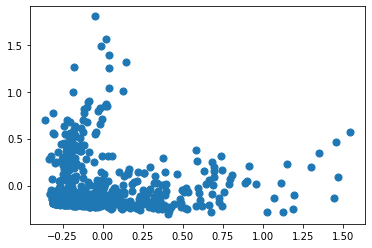

In [33]:
player_no_goalkeepers_df_pca = estimator.fit_transform(player_no_goalkeepers_df[player_columns])
print(estimator.explained_variance_ratio_) 

fig, ax = plt.subplots()
ax.scatter(player_no_goalkeepers_df_pca[:,0], player_no_goalkeepers_df_pca[:,1] ,s=50)

for i in range(0,len(player_no_goalkeepers_df_pca)):
    ax.annotate("", (player_no_goalkeepers_df_pca[i,0], player_no_goalkeepers_df_pca[i,1]))

Varianza mantenida: 0.67365058

In [35]:
# Influencia de cada uno de las columnas en las componentes de PCA
pd.DataFrame(np.matrix.transpose(estimator.components_), columns=['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5'], index=player_columns)

,PC-1,PC-2,PC-3,PC-4,PC-5
7mGoals,0.090623,0.246444,-0.175670,-0.102211,0.413648
7mMissed,0.093579,0.295585,-0.207445,-0.141670,0.547586
6mGoals,0.088475,-0.003795,0.337777,-0.181497,0.251961
6mMissed,0.104310,-0.007734,0.366122,-0.193508,0.346956
WingGoals,-0.086664,0.454697,-0.075240,-0.132524,-0.212085
WingMissed,-0.091730,0.472472,-0.097990,-0.139959,-0.237464
BTGoals,0.302055,-0.032531,-0.111098,0.005536,-0.023487
BTMissed,0.324212,-0.064668,-0.173673,0.065531,-0.008341
FBGoals,0.124990,0.442873,0.092516,-0.066138,-0.236214
FBMissed,0.083442,0.305177,0.105682,-0.136948,0.072941


------------
# Detección de outliers

Primero probaremos que outliers nos detecta DBSCAN.
Por equipos no tiene mucho sentido aplicar DBSCAN para los outliers porque son solo 32 (un número demasiado bajo).

#### DBSCAN Por jugadores (con porteros)

In [36]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
player_goalkeepers_dist = dist.pairwise(player_goalkeepers_df_pca)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


In [37]:
# Sacado teniendo en cuenta el numero de jugadores
minPts=5 #@param {type:"slider", min:1, max:10}

A = kneighbors_graph(player_goalkeepers_df_pca, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(player_goalkeepers_df_pca):
    for j in range(len(player_goalkeepers_df_pca)):
        if Ar[i][j] != 0:
          seq.append(player_goalkeepers_dist[i][j])
            
seq.sort()
fig = px.line(x=np.arange(0, len(seq), 1), y=seq)
fig.show()

In [38]:
# 0.2 - 1.0 debido al codo del gráfico. Es el rango de valores del codo en el eje Y.
results = []
for eps in np.arange(0.2, 1.0, 0.01):
  db = DBSCAN(eps, min_samples=minPts).fit(player_goalkeepers_df)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  results.append([eps, n_clusters_, n_outliers])

# Se imprimen los resultados para elegir el eps
from tabulate import tabulate
print(tabulate(results, headers = ("eps", "clusters", "outliers")))

  eps    clusters    outliers
-----  ----------  ----------
 0.2            3         399
 0.21           2         394
 0.22           2         386
 0.23           2         382
 0.24           2         373
 0.25           2         366
 0.26           2         357
 0.27           2         349
 0.28           2         335
 0.29           2         329
 0.3            2         317
 0.31           4         300
 0.32           4         291
 0.33           4         277
 0.34           3         267
 0.35           3         259
 0.36           2         241
 0.37           2         230
 0.38           2         219
 0.39           2         213
 0.4            2         201
 0.41           3         179
 0.42           3         169
 0.43           3         160
 0.44           2         153
 0.45           2         143
 0.46           2         140
 0.47           2         135
 0.48           2         129
 0.49           2         126
 0.5            2         123
 0.51     

In [39]:
print(player_goalkeepers_df.shape)
eps = 0.99 #@param {type:"slider", min:0.2, max:1.0, step:0.01}
db = DBSCAN(eps=eps, min_samples=minPts).fit(player_goalkeepers_df)
player_goalkeepers_df['dbscan_group'] = db.labels_
player_goalkeepers_df[player_goalkeepers_df['dbscan_group'] == -1]



(607, 20)


,7mGoals,7mMissed,6mGoals,6mMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,...,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS,Time,dbscan_group
Name,,,,,,,,,,,,,,,,,,,,,
BENTALEB Mohamed Amine,0.045455,0.0,0.090909,0.083333,0.000000,0.1,0.20,0.333333,0.333333,0.0,...,1.0,0.086957,0.28125,0.428571,0.454545,0.421053,0.636364,0.090909,0.733111,-1
FEUCHTMANN Erwin,0.363636,0.6,0.181818,0.166667,0.000000,0.0,0.85,0.666667,0.750000,0.4,...,0.5,0.347826,0.53125,0.571429,0.454545,0.657895,0.545455,0.363636,0.860274,-1
HARCHAOUI Amine,0.136364,0.0,0.060606,0.166667,0.000000,0.0,0.25,0.500000,0.416667,0.2,...,0.5,0.608696,0.75000,1.000000,0.363636,0.631579,0.363636,0.636364,0.830209,-1
SAGOSEN Sander,1.000000,0.6,0.090909,0.083333,0.000000,0.0,0.35,0.166667,0.333333,0.2,...,0.5,0.782609,0.68750,0.285714,0.454545,1.000000,0.181818,0.181818,0.625978,-1
SALINAS Rodrigo,0.227273,0.6,0.121212,0.166667,0.000000,0.0,0.35,0.333333,0.500000,0.0,...,0.0,0.652174,0.40625,0.714286,0.181818,0.894737,1.000000,0.090909,0.762092,-1
WANNE Hampus,0.863636,0.8,0.151515,0.000000,1.000000,0.9,0.00,0.000000,0.750000,1.0,...,0.0,0.043478,0.00000,0.071429,0.000000,0.000000,0.181818,0.000000,0.874082,-1
WEBER Robert,0.772727,0.8,0.030303,0.000000,0.526316,0.4,0.00,0.000000,0.250000,1.0,...,1.0,0.000000,0.00000,0.178571,0.090909,0.078947,0.272727,0.000000,0.737045,-1


#### DBSCAN Por jugadores (sin porteros)

In [40]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
player_no_goalkeepers_dist = dist.pairwise(player_no_goalkeepers_df_pca)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning:

sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3



In [41]:
# Sacado teniendo en cuenta el numero de jugadores
minPts=5 #@param {type:"slider", min:1, max:10}

A = kneighbors_graph(player_no_goalkeepers_df_pca, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(player_no_goalkeepers_df_pca):
    for j in range(len(player_no_goalkeepers_df_pca)):
        if Ar[i][j] != 0:
          seq.append(player_no_goalkeepers_dist[i][j])
            
seq.sort()
fig = px.line(x=np.arange(0, len(seq), 1), y=seq)
fig.show()

In [42]:
# 0.2 - 0.9 debido al codo del gráfico, se saca del eje y.
results = []
for eps in np.arange(0.2, 1.0, 0.01):
  db = DBSCAN(eps, min_samples=minPts).fit(player_no_goalkeepers_df)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  #print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))
  results.append([eps, n_clusters_, n_outliers])

#print results
from tabulate import tabulate
print(tabulate(results, headers = ("eps", "clusters", "outliers")))

  eps    clusters    outliers
-----  ----------  ----------
 0.2            3         398
 0.21           2         394
 0.22           2         386
 0.23           2         382
 0.24           2         373
 0.25           2         367
 0.26           2         358
 0.27           2         350
 0.28           2         338
 0.29           2         331
 0.3            2         319
 0.31           4         300
 0.32           4         291
 0.33           4         277
 0.34           3         267
 0.35           3         259
 0.36           2         241
 0.37           2         230
 0.38           2         219
 0.39           2         213
 0.4            2         201
 0.41           3         179
 0.42           3         169
 0.43           3         160
 0.44           2         153
 0.45           2         144
 0.46           2         140
 0.47           2         135
 0.48           2         129
 0.49           2         126
 0.5            2         123
 0.51     

In [43]:
print(player_no_goalkeepers_df.shape)
eps = 0.99 #@param {type:"slider", min:0.2, max:1.0, step:0.01}
db = DBSCAN(eps=eps, min_samples=minPts).fit(player_no_goalkeepers_df)
player_no_goalkeepers_df['dbscan_group'] = db.labels_
player_no_goalkeepers_df[player_no_goalkeepers_df['dbscan_group'] == -1]


(561, 20)


,7mGoals,7mMissed,6mGoals,6mMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,...,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS,Time,dbscan_group
Name,,,,,,,,,,,,,,,,,,,,,
BENTALEB Mohamed Amine,0.045455,0.0,0.090909,0.083333,0.000000,0.1,0.20,0.333333,0.333333,0.0,...,1.0,0.086957,0.28125,0.428571,0.454545,0.421053,0.636364,0.090909,0.733111,-1
FEUCHTMANN Erwin,0.363636,0.6,0.181818,0.166667,0.000000,0.0,0.85,0.666667,0.750000,0.4,...,0.5,0.347826,0.53125,0.571429,0.454545,0.657895,0.545455,0.363636,0.860274,-1
HARCHAOUI Amine,0.136364,0.0,0.060606,0.166667,0.000000,0.0,0.25,0.500000,0.416667,0.2,...,0.5,0.608696,0.75000,1.000000,0.363636,0.631579,0.363636,0.636364,0.830209,-1
SAGOSEN Sander,1.000000,0.6,0.090909,0.083333,0.000000,0.0,0.35,0.166667,0.333333,0.2,...,0.5,0.782609,0.68750,0.285714,0.454545,1.000000,0.181818,0.181818,0.625978,-1
SALINAS Rodrigo,0.227273,0.6,0.121212,0.166667,0.000000,0.0,0.35,0.333333,0.500000,0.0,...,0.0,0.652174,0.40625,0.714286,0.181818,0.894737,1.000000,0.090909,0.762092,-1
WANNE Hampus,0.863636,0.8,0.151515,0.000000,1.000000,0.9,0.00,0.000000,0.750000,1.0,...,0.0,0.043478,0.00000,0.071429,0.000000,0.000000,0.181818,0.000000,0.874082,-1
WEBER Robert,0.772727,0.8,0.030303,0.000000,0.526316,0.4,0.00,0.000000,0.250000,1.0,...,1.0,0.000000,0.00000,0.178571,0.090909,0.078947,0.272727,0.000000,0.737045,-1


#### JACKKNIFE Por equipos (sin porteros)

In [44]:
def linreg_ols_lu(y, X):
    import numpy as np
    try:  # solve OLS formula
        return np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
    except np.linalg.LinAlgError:
        print("LinAlgError: X*X' is singular or not square.")
        return None

def jk_handler(data):
    return linreg_ols_lu( data[:,0], data[:,1:] );


Delete-1 Jackknife, N=32
                                 PCA_VAL_1  PCA_VAL_2 
                      p-Values:    0.94963    0.95711 
                      t-Scores:   -0.06372   -0.05424 
 Jackknife Standard Error (SE):    0.12410    0.44228 
   Jackknife Estimates (theta):   -0.008     -0.024   
     Jackknife Biased Estimate:    0.000      0.001   
          Full Sample Estimate:    0.000      0.000   
[7.80625564e-18 2.65956086e-17]


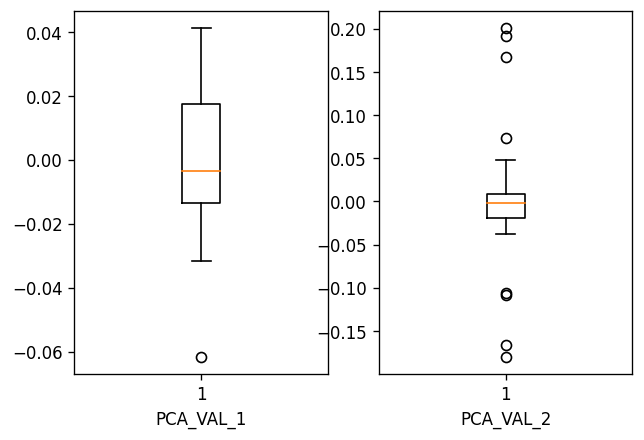

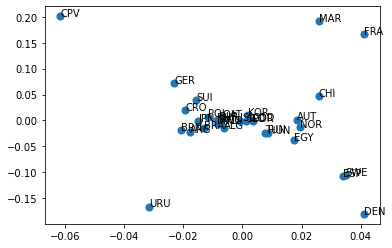

In [45]:
jackknife_team_no_goalkeepers_df = team_no_goalkeepers_df.copy()

jackknife_team_no_goalkeepers_df['y_train'] = [i[0] for i in team_no_goalkeepers_df_pca]
jackknife_team_no_goalkeepers_df['x_train'] = [i[1] for i in team_no_goalkeepers_df_pca]

y_train = jackknife_team_no_goalkeepers_df['y_train'].values

X_train = np.c_[np.ones(shape=(len(y_train),)), jackknife_team_no_goalkeepers_df['x_train'].values]

theta_subsample, theta_fullsample = jk.jk_loop(
    jk_handler, np.c_[y_train, X_train], d=1)

pvalues, tscores, theta_jack, se_jack, theta_biased = jk.jk_stats(
    theta_subsample, theta_fullsample)

jk.jk_print(
    pvalues, tscores, theta_jack, se_jack, theta_biased, theta_fullsample, 
    varnames=['PCA_VAL_1', 'PCA_VAL_2'], N=len(y_train), d=1)

print(theta_fullsample)
fig = plt.figure(dpi=120)
plt.subplot(121)
plt.boxplot(theta_subsample[:,0]);
plt.xlabel('PCA_VAL_1');
plt.subplot(122)
plt.boxplot(theta_subsample[:,1]);
plt.xlabel('PCA_VAL_2');

fig, ax = plt.subplots()
ax.scatter(theta_subsample[:,0], theta_subsample[:,1],s=50)

for i in range(0,len(jackknife_team_no_goalkeepers_df)):
    ax.annotate(jackknife_team_no_goalkeepers_df.index[i], (theta_subsample[:,0][i], theta_subsample[:,1][i]))

Nos detecta como outlier CPV y, secundariamente URU y DEN

#### JACKKNIFE Por equipos (sin porteros ni Presidents Cup)


Delete-1 Jackknife, N=32
                                 PCA_VAL_1  PCA_VAL_2 
                      p-Values:    0.95452    0.97471 
                      t-Scores:   -0.05753   -0.03198 
 Jackknife Standard Error (SE):    0.14870    0.70527 
   Jackknife Estimates (theta):   -0.009     -0.023   
     Jackknife Biased Estimate:    0.000      0.001   
          Full Sample Estimate:    0.000      0.000   
[7.63278329e-17 7.91757456e-33]


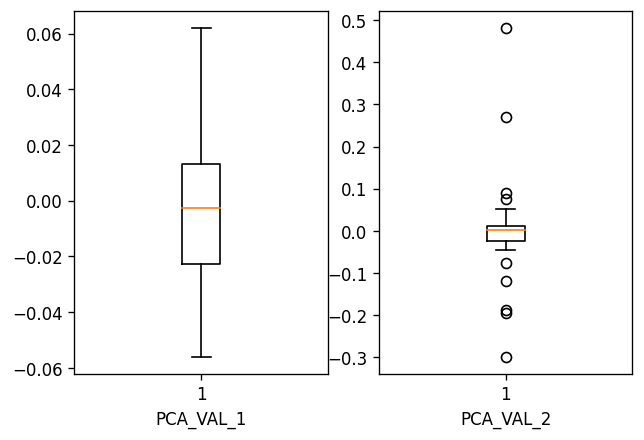

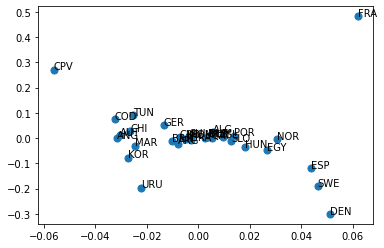

In [46]:
jackknife_team_no_presidentscup_df = team_no_presidentscup_df.copy()
jackknife_team_no_presidentscup_df['y_train'] = [i[0] for i in team_no_presidentscup_df_pca]
jackknife_team_no_presidentscup_df['x_train'] = [i[1] for i in team_no_presidentscup_df_pca]

y_train = jackknife_team_no_presidentscup_df['y_train'].values
X_train = np.c_[np.ones(shape=(len(y_train),)), jackknife_team_no_presidentscup_df['x_train'].values]
theta_subsample, theta_fullsample = jk.jk_loop(
    jk_handler, np.c_[y_train, X_train], d=1)

pvalues, tscores, theta_jack, se_jack, theta_biased = jk.jk_stats(
    theta_subsample, theta_fullsample)
jk.jk_print(
    pvalues, tscores, theta_jack, se_jack, theta_biased, theta_fullsample, 
    varnames=['PCA_VAL_1', 'PCA_VAL_2'], N=len(y_train), d=1)

print(theta_fullsample)
fig = plt.figure(dpi=120)
plt.subplot(121)
plt.boxplot(theta_subsample[:,0]);
plt.xlabel('PCA_VAL_1');
plt.subplot(122)
plt.boxplot(theta_subsample[:,1]);
plt.xlabel('PCA_VAL_2');

fig, ax = plt.subplots()
ax.scatter(theta_subsample[:,0], theta_subsample[:,1],s=50)

for i in range(0,len(jackknife_team_no_presidentscup_df)):
    ax.annotate(jackknife_team_no_presidentscup_df.index[i], (theta_subsample[:,0][i], theta_subsample[:,1][i]))

Detecta 2 outliers obvios: FRA y CPV.
También podríamos considerar DEN como outlier.

#### JACKKNIFE Por jugadores (con porteros)


Delete-1 Jackknife, N=607
                                 PCA_VAL_1  PCA_VAL_2 
                      p-Values:    0.98726    0.95628 
                      t-Scores:    0.01597    0.05484 
 Jackknife Standard Error (SE):    0.01358    0.04078 
   Jackknife Estimates (theta):    0.000      0.002   
     Jackknife Biased Estimate:   -0.000     -0.000   
          Full Sample Estimate:   -0.000      0.000   
[-1.82903299e-17  8.77232243e-16]


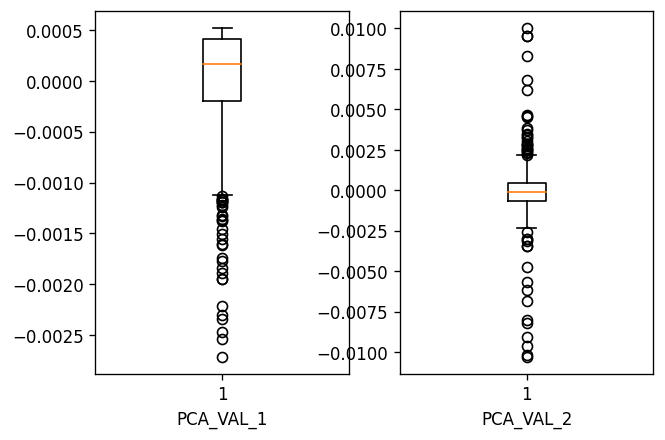

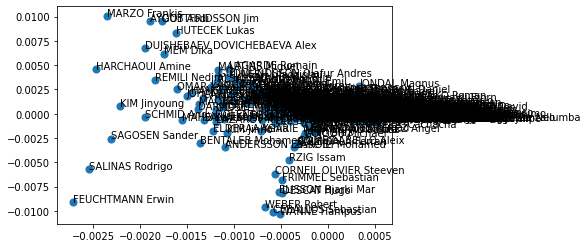

In [47]:
jackknife_player_goalkeepers_df = player_goalkeepers_df.copy()
jackknife_player_goalkeepers_df['y_train'] = [i[0] for i in player_goalkeepers_df_pca]
jackknife_player_goalkeepers_df['x_train'] = [i[1] for i in player_goalkeepers_df_pca]

y_train = jackknife_player_goalkeepers_df['y_train'].values
X_train = np.c_[np.ones(shape=(len(y_train),)), jackknife_player_goalkeepers_df['x_train'].values]
theta_subsample, theta_fullsample = jk.jk_loop(
    jk_handler, np.c_[y_train, X_train], d=1)

pvalues, tscores, theta_jack, se_jack, theta_biased = jk.jk_stats(
    theta_subsample, theta_fullsample)
jk.jk_print(
    pvalues, tscores, theta_jack, se_jack, theta_biased, theta_fullsample, 
    varnames=['PCA_VAL_1', 'PCA_VAL_2'], N=len(y_train), d=1)

print(theta_fullsample)
fig = plt.figure(dpi=120)
plt.subplot(121)
plt.boxplot(theta_subsample[:,0]);
plt.xlabel('PCA_VAL_1');
plt.subplot(122)
plt.boxplot(theta_subsample[:,1]);
plt.xlabel('PCA_VAL_2');

fig, ax = plt.subplots()
ax.scatter(theta_subsample[:,0], theta_subsample[:,1],s=50)

for i in range(0,len(jackknife_player_goalkeepers_df)):
    ax.annotate(jackknife_player_goalkeepers_df.index[i], (theta_subsample[:,0][i], theta_subsample[:,1][i]))

La inclusión de porteros hace más difícil ver outliers en el boxplot.

#### JACKKNIFE Por jugadores (sin porteros)


Delete-1 Jackknife, N=561
                                 PCA_VAL_1  PCA_VAL_2 
                      p-Values:    0.99688    0.99095 
                      t-Scores:   -0.00391   -0.01134 
 Jackknife Standard Error (SE):    0.01420    0.03704 
   Jackknife Estimates (theta):   -0.000     -0.000   
     Jackknife Biased Estimate:    0.000      0.000   
          Full Sample Estimate:    0.000      0.000   
[1.20224686e-17 4.13418346e-16]


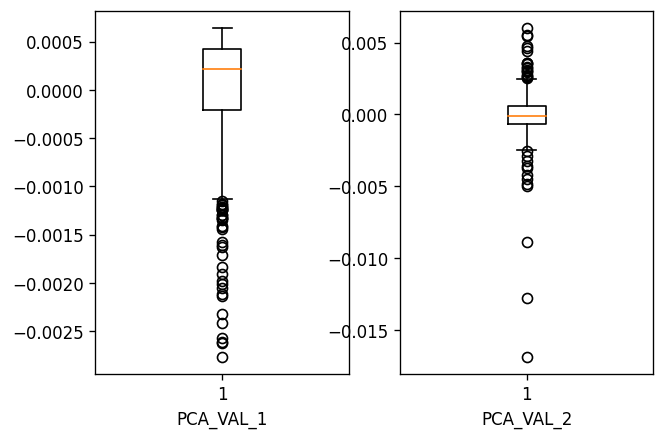

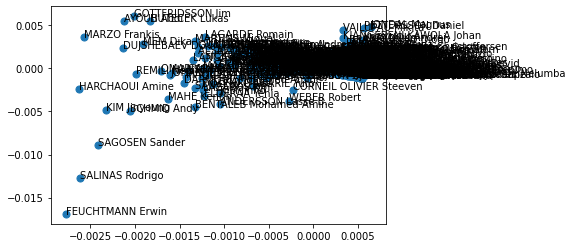

In [48]:
jackknife_player_no_goalkeepers_df = player_no_goalkeepers_df.copy()
jackknife_player_no_goalkeepers_df['y_train'] = [i[0] for i in player_no_goalkeepers_df_pca]
jackknife_player_no_goalkeepers_df['x_train'] = [i[1] for i in player_no_goalkeepers_df_pca]

y_train = jackknife_player_no_goalkeepers_df['y_train'].values
X_train = np.c_[np.ones(shape=(len(y_train),)), jackknife_player_no_goalkeepers_df['x_train'].values]
theta_subsample, theta_fullsample = jk.jk_loop(
    jk_handler, np.c_[y_train, X_train], d=1)

pvalues, tscores, theta_jack, se_jack, theta_biased = jk.jk_stats(
    theta_subsample, theta_fullsample)
jk.jk_print(
    pvalues, tscores, theta_jack, se_jack, theta_biased, theta_fullsample, 
    varnames=['PCA_VAL_1', 'PCA_VAL_2'], N=len(y_train), d=1)

print(theta_fullsample)
fig = plt.figure(dpi=120)
plt.subplot(121)
plt.boxplot(theta_subsample[:,0]);
plt.xlabel('PCA_VAL_1');
plt.subplot(122)
plt.boxplot(theta_subsample[:,1]);
plt.xlabel('PCA_VAL_2');

fig, ax = plt.subplots()
ax.scatter(theta_subsample[:,0], theta_subsample[:,1],s=50)

for i in range(0,len(jackknife_player_no_goalkeepers_df)):
    ax.annotate(jackknife_player_no_goalkeepers_df.index[i], (theta_subsample[:,0][i], theta_subsample[:,1][i]))

Los 3 jugadores más obviamente marcados como outliers son Erwin Feuchtmann, Rodrigo Salinas y Sander Sagosen

-----
# Eliminación de outliers

NOTA: NORMALMENTE SE BUSCA UN P-VALUE CERCANO A 0 (QUE DEMUESTRA QUE UNA HIPÓTESIS NO SE DEBE A CASUALIDAD) (PUEDE SER QUE CON JACKKNIFE SEA AL REVÉS, PREGUNTAR?)
(si no se puede aplicar  jackknife, quizás podamos quitar outliers manualmente y usar dbscan para los df de jugadores)

#### Por jugadores (con porteros)

Se eliminarán los detectados por ambos algoritmos

In [49]:
player_goalkeepers_df = player_goalkeepers_df[player_goalkeepers_df['dbscan_group'] != -1]
player_goalkeepers_df = player_goalkeepers_df.drop(['dbscan_group'], axis=1)

# Normalizamos los datos
player_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS', 'Time']] = min_max_scaler.fit_transform(player_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS', 'Time']])
player_goalkeepers_df.head()

,7mGoals,7mMissed,6mGoals,6mMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,EGGoals,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS,Time
Name,,,,,,,,,,,,,,,,,,,,
A.HUSAIN Mohamed,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.5,0.000000,0.00000,0.08,0.000000,0.027778,0.0,0.0,0.582989
AAR William,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.00,0.000000,0.000000,0.0,0.0,0.000000
ABALO Luc,0.0,0.0,0.030303,0.000000,0.578947,0.6,0.0,0.0,0.166667,0.4,0.0,0.0,0.000000,0.00000,0.04,0.090909,0.055556,0.0,0.0,0.690764
ABDELFATTAH Omar,0.0,0.0,0.000000,0.083333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.03125,0.00,0.000000,0.000000,0.0,0.0,0.017581
ABDELKADER Rahim,0.0,0.0,0.060606,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.130435,0.09375,0.08,0.090909,0.055556,0.0,0.0,0.341709


#### Por jugadores (sin porteros)

Se eliminarán lso detectados por ambos algoritmos

In [50]:
player_no_goalkeepers_df = player_no_goalkeepers_df[player_no_goalkeepers_df['dbscan_group'] != -1]
player_no_goalkeepers_df = player_no_goalkeepers_df.drop(['dbscan_group'], axis=1)

# Normalizamos los datos
player_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS', 'Time']] = min_max_scaler.fit_transform(player_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS', 'Time']])
player_no_goalkeepers_df.head()

,7mGoals,7mMissed,6mGoals,6mMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,EGGoals,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS,Time
Name,,,,,,,,,,,,,,,,,,,,
A.HUSAIN Mohamed,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.5,0.000000,0.00000,0.08,0.000000,0.027778,0.0,0.0,0.582989
AAR William,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.00,0.000000,0.000000,0.0,0.0,0.000000
ABALO Luc,0.0,0.0,0.030303,0.000000,0.578947,0.6,0.0,0.0,0.166667,0.4,0.0,0.0,0.000000,0.00000,0.04,0.090909,0.055556,0.0,0.0,0.690764
ABDELFATTAH Omar,0.0,0.0,0.000000,0.083333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.03125,0.00,0.000000,0.000000,0.0,0.0,0.017581
ABDELKADER Rahim,0.0,0.0,0.060606,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.130435,0.09375,0.08,0.090909,0.055556,0.0,0.0,0.341709


Los outliers detectados con Jackknife fueron ya incluidos en los detectados con dbscan.

#### Por equipos (sin porteros)

Se eliminan los 3 detectados con jackknife 

In [51]:
team_no_goalkeepers_df.drop(team_no_goalkeepers_df[team_no_goalkeepers_df.index == 'CPV'].index, inplace = True)
team_no_goalkeepers_df.drop(team_no_goalkeepers_df[team_no_goalkeepers_df.index == 'URU'].index, inplace = True)
team_no_goalkeepers_df.drop(team_no_goalkeepers_df[team_no_goalkeepers_df.index == 'DEN'].index, inplace = True)
# Normalizamos los datos
team_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']] = min_max_scaler.fit_transform(team_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])


#### Por equipos (sin porteros ni presidents cup)

Se eliminan los 3 equipos detectados por Jackknife, así como URU por observación del PCA

In [52]:
team_no_presidentscup_df.drop(team_no_presidentscup_df[team_no_presidentscup_df.index == 'FRA'].index, inplace = True)
team_no_presidentscup_df.drop(team_no_presidentscup_df[team_no_presidentscup_df.index == 'CPV'].index, inplace = True)
team_no_presidentscup_df.drop(team_no_presidentscup_df[team_no_presidentscup_df.index == 'DEN'].index, inplace = True)
team_no_presidentscup_df.drop(team_no_presidentscup_df[team_no_presidentscup_df.index == 'URU'].index, inplace = True)
# Normalizamos los datos
team_no_presidentscup_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']] = min_max_scaler.fit_transform(team_no_presidentscup_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])


----------------
# Volver a aplicar PCA sin los outliers

#### Por equipos (Sin porteros)

[0.36673078 0.12608776 0.10395752 0.07004409 0.05626504]


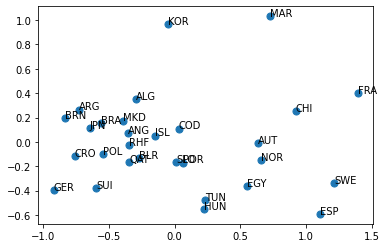

In [53]:
team_no_goalkeepers_df_pca = estimator.fit_transform(team_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print(estimator.explained_variance_ratio_) 


fig, ax = plt.subplots()
ax.scatter(team_no_goalkeepers_df_pca[:,0], team_no_goalkeepers_df_pca[:,1] ,s=50)

for i in range(0,len(team_no_goalkeepers_df_pca)):
    ax.annotate(team_no_goalkeepers_df.index[i], (team_no_goalkeepers_df_pca[i,0], team_no_goalkeepers_df_pca[i,1]))

Varianza mantenida: 0.72308519

Varianza mantenida con outliers: 0.75848299

Sin outliers el PCA es menos fiable.

#### Por equipos (sin presidents cup)

[0.48338633 0.09589012 0.09297164 0.06510943 0.05383204]


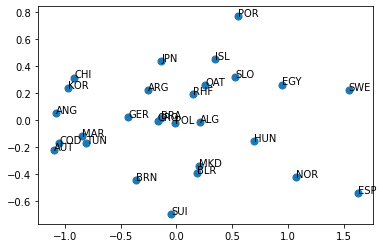

In [54]:
team_no_presidentscup_df_pca = estimator.fit_transform(team_no_presidentscup_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print(estimator.explained_variance_ratio_) 

fig, ax = plt.subplots()
ax.scatter(team_no_presidentscup_df_pca[:,0], team_no_presidentscup_df_pca[:,1] ,s=50)

for i in range(0,len(team_no_presidentscup_df_pca)):
    ax.annotate(team_no_presidentscup_df.index[i], (team_no_presidentscup_df_pca[i,0], team_no_presidentscup_df_pca[i,1]))


Varianza mantenida: 0.79248223

Varianza mantenida con outliers: 0.81703576

Sin outliers el PCA es menos fiable.

#### Por jugador (Con porteros)

[0.241271   0.19153535 0.11118751 0.06977617 0.06059404]


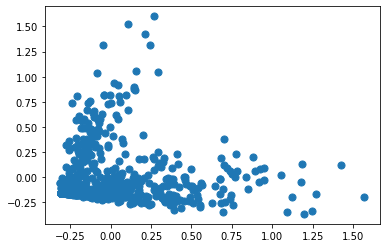

In [55]:
player_goalkeepers_df_pca = estimator.fit_transform(player_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print(estimator.explained_variance_ratio_) 

fig, ax = plt.subplots()
ax.scatter(player_goalkeepers_df_pca[:,0], player_goalkeepers_df_pca[:,1] ,s=50)

for i in range(0,len(player_goalkeepers_df_pca)):
    ax.annotate("", (player_goalkeepers_df_pca[i,0], player_goalkeepers_df_pca[i,1]))

Varianza mantenida: 0.67436409

Varianza mantenida con outliers: 0.67987162

Sin outliers el PCA es menos fiable.

#### Por jugador (Sin porteros)

[0.23184352 0.19001926 0.11233037 0.07149834 0.06201339]


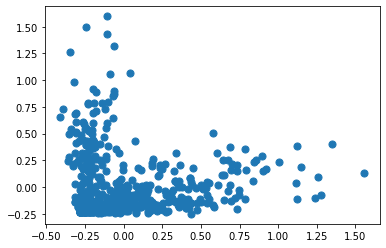

In [56]:
player_no_goalkeepers_df_pca = estimator.fit_transform(player_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print(estimator.explained_variance_ratio_) 

fig, ax = plt.subplots()
ax.scatter(player_no_goalkeepers_df_pca[:,0], player_no_goalkeepers_df_pca[:,1] ,s=50)

for i in range(0,len(player_no_goalkeepers_df_pca)):
    ax.annotate("", (player_no_goalkeepers_df_pca[i,0], player_no_goalkeepers_df_pca[i,1]))

Varianza mantenida: 0.66770495

Varianza mantenida con outliers: 0.67365058

Sin outliers el PCA es menos fiable.

-------------------
# Ejecución del algoritmo

Por lo que se nos ha comentado en clase, no hay ninguna técnica específica para calcular el mejor valor del número de componentes al contrario de lo que pasaba con la K de K-means. (? silhuette)

#### Por equipos (Sin porteros)

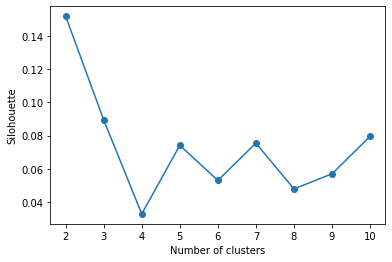

In [57]:
silhouettes = []

for i in range(2, 11):
    em = GaussianMixture(n_components=i,covariance_type='full', init_params='k-means++')
    em.fit(team_no_goalkeepers_df)
    labels = em.predict(team_no_goalkeepers_df)
    silhouettes.append(metrics.silhouette_score(team_no_goalkeepers_df, labels))

# Se dibuja la silueta obtenida para elegir el número de gaussianos
plt.plot(range(2,11), silhouettes , marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silohouette')
plt.show()

De nuevo, muy estocástico (se ha probado con varios métodos de inicialización, pero no se ha detectado estabilidad en los resultados con ninguno)

Se buscan valores altos de silueta, pero varía bastante.
Los valores más altos están entre 2 y 3

Con otras covarianzas no cambia demasiado.

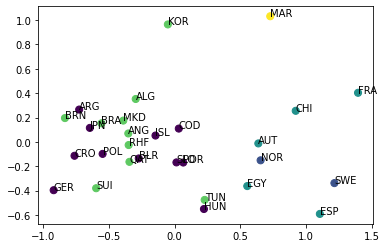

In [58]:
n_components = 5 #@param {type:"slider", min:2, max:10}
em = GaussianMixture(n_components=n_components,covariance_type='full', init_params='k-means++')
em.fit(team_no_goalkeepers_df)
labels = em.predict(team_no_goalkeepers_df)

fig, ax = plt.subplots()
ax.scatter(team_no_goalkeepers_df_pca[:,0], team_no_goalkeepers_df_pca[:,1] ,s=50, c=labels)

for i in range(0,len(team_no_goalkeepers_df_pca)):
    ax.annotate(team_no_goalkeepers_df.index[i], (team_no_goalkeepers_df_pca[i,0], team_no_goalkeepers_df_pca[i,1]))

#Guardar el resultado como excel para analizar
team_no_goalkeepers_df['cluster']=labels
team_no_goalkeepers_df.to_excel("result_team_no_goalkeepers-"+str(n_components)+"_clusters.xlsx")  

#### Por equipos (Sin porteros ni Presidents Cup)

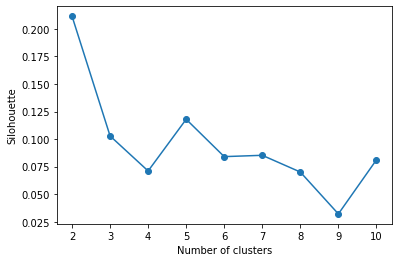

In [59]:
silhouettes = []

for i in range(2, 11):
    em = GaussianMixture(n_components=i,covariance_type='full', init_params='k-means++')
    em.fit(team_no_presidentscup_df)
    labels = em.predict(team_no_presidentscup_df)
    silhouettes.append(metrics.silhouette_score(team_no_presidentscup_df, labels))

# Se dibuja la silueta obtenida para elegir el número de gaussianos
plt.plot(range(2,11), silhouettes , marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silohouette')
plt.show()

De nuevo, muy estocástico (se ha probado con varios métodos de inicialización, pero no se ha detectado estabilidad en los resultados con ninguno)

Se buscan valores altos de silueta, pero varía bastante.
Los valores más altos están entre 2 y 3

Con otras covarianzas no cambia demasiado.

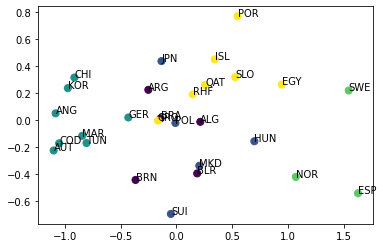

In [60]:
n_components = 5 #@param {type:"slider", min:2, max:10}
em = GaussianMixture(n_components=n_components,covariance_type='full', init_params='k-means++')
em.fit(team_no_presidentscup_df)
labels = em.predict(team_no_presidentscup_df)
ig, ax = plt.subplots()

ax.scatter(team_no_presidentscup_df_pca[:,0], team_no_presidentscup_df_pca[:,1] ,s=50, c=labels)

for i in range(0,len(team_no_presidentscup_df_pca)):
    ax.annotate(team_no_presidentscup_df.index[i], (team_no_presidentscup_df_pca[i,0], team_no_presidentscup_df_pca[i,1]))

#Guardar el resultado como excel para analizar
team_no_presidentscup_df['cluster']=labels
team_no_presidentscup_df.to_excel("result_team_no_presidents_cup-"+str(n_components)+"_clusters.xlsx")  

#### Por jugador (Con porteros)

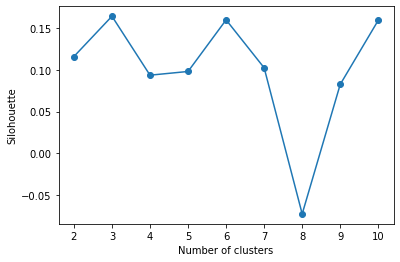

In [61]:
silhouettes = []

for i in range(2, 11):
    em = GaussianMixture(n_components=i,covariance_type='full', init_params='k-means++')
    em.fit(player_goalkeepers_df)
    labels = em.predict(player_goalkeepers_df)
    silhouettes.append(metrics.silhouette_score(player_goalkeepers_df, labels))

# Se dibuja la silueta obtenida para elegir el número de gaussianos
plt.plot(range(2,11), silhouettes , marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silohouette')
plt.show()

Muy estocástico (se ha probado con varios métodos de inicialización, pero no se ha detectado estabilidad en los resultados con ninguno)

Se buscan valores altos de silueta, pero varía bastante (normalmente es el 3 o el 4).

Con otras covarianzas no cambia demasiado.

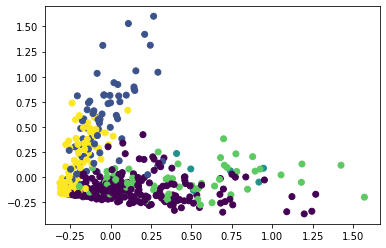

In [62]:
n_components = 5 #@param {type:"slider", min:2, max:10}
em = GaussianMixture(n_components=n_components,covariance_type='full', init_params='k-means++')
em.fit(player_goalkeepers_df)
labels = em.predict(player_goalkeepers_df)

plt.scatter(np.array([i[0] for i in player_goalkeepers_df_pca]), np.array([i[1] for i in player_goalkeepers_df_pca]), c=labels)

#Guardar el resultado como excel para analizar
player_goalkeepers_df['cluster']=labels
player_goalkeepers_df.to_excel("result_players_goalkeepers-"+str(n_components)+"_clusters.xlsx")  

#### Por jugador (Sin porteros)

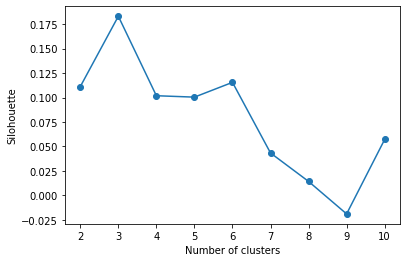

In [63]:
silhouettes = []

for i in range(2, 11):
    em = GaussianMixture(n_components=i,covariance_type='full', init_params='k-means++')
    em.fit(player_no_goalkeepers_df)
    labels = em.predict(player_no_goalkeepers_df)
    silhouettes.append(metrics.silhouette_score(player_no_goalkeepers_df, labels))

# Se dibuja la silueta obtenida para elegir el número de gaussianos
plt.plot(range(2,11), silhouettes , marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silohouette')
plt.show()

De nuevo, muy estocástico (se ha probado con varios métodos de inicialización, pero no se ha detectado estabilidad en los resultados con ninguno)

Se buscan valores altos de silueta, pero varía bastante.
Los valores más altos están entre 3, 4 y 5.

Con otras covarianzas no cambia demasiado.

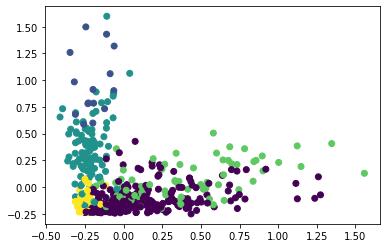

In [64]:
n_components = 5 #@param {type:"slider", min:2, max:10}
em = GaussianMixture(n_components=n_components,covariance_type='full', init_params='k-means++')
em.fit(player_no_goalkeepers_df)
labels = em.predict(player_no_goalkeepers_df)

plt.scatter(np.array([i[0] for i in player_no_goalkeepers_df_pca]), np.array([i[1] for i in player_no_goalkeepers_df_pca]), c=labels)

#Guardar el resultado como excel para analizar
player_no_goalkeepers_df['cluster']=labels
player_no_goalkeepers_df.to_excel("result_players_no_goalkeepers-"+str(n_components)+"_clusters.xlsx")  